In [ ]:
import gdown


url = "https://drive.google.com/drive/folders/1qhhXqA8CjaJs7-E4SjXfhwWn2z4UtABA"
gdown.download_folder(url, quiet=True)

['/content/Datacon Data/Database_1.xlsx',
 '/content/Datacon Data/Database_2.xlsx',
 '/content/Datacon Data/Database_3.xlsx',
 '/content/Datacon Data/Database_4.xlsx',
 '/content/Datacon Data/Database_5.xlsx']

In [ ]:
import pandas as pd
import numpy as np
import math


db1 = pd.read_excel('Datacon Data/Database_1.xlsx')
db2 = pd.read_excel('Datacon Data/Database_2.xlsx')
db3 = pd.read_excel('Datacon Data/Database_3.xlsx')
db4 = pd.read_excel('Datacon Data/Database_4.xlsx')
db5 = pd.read_excel('Datacon Data/Database_5.xlsx')

In [ ]:
db1.columns, db2.columns, db3.columns, db4.columns, db5.columns

(Index(['Material type', 'Elements', 'Electronegativity', 'Ionic radius',
        'Core size (nm)', 'Hydro size (nm)', 'Surface charge (mV)',
        'Surface area (m2/g)', 'Cell type', 'Exposure dose (ug/mL)',
        'Number of atoms', 'Molecular weight (g/mol)',
        'Topological polar surface area (Å²)', 'a (Å)', 'b (Å)', 'c (Å)',
        'α (°)', 'β (°)', 'γ (°)', 'Density (g/cm3)', 'Viability (%)'],
       dtype='object'),
 Index(['Nanoparticle', 'Type: Organic (O)/inorganic (I)', 'coat',
        'Diameter (nm)', 'Concentration μM', 'Zeta potential (mV)', 'Cells',
        'Cell line (L)/primary cells (P)', 'Human(H)/Animal(A) cells',
        'Animal?', 'Cell morphology', 'Cell age: embryonic (E), Adult (A)',
        'Cell-organ/tissue source', 'Exposure time (h)', 'Test',
        'Test indicator', 'Biochemical metric', '% Cell viability',
        'Interference checked (Y/N)', 'Colloidal stability checked (Y/N)',
        'Positive control (Y/N)', 'Publication year', 'Particle I

Заметим, что db1 и db4 имеют одинаковые колонки. Можем сразу их объединить

In [ ]:
db1 = db1.append(db4, ignore_index=True)
db4 = db5

In [ ]:
for df in [db1,db2,db3,db4]:
    print(df.shape[0])
    print(df.isna().sum())
    print('----------------------------')

1562
Material type                            2
Elements                                 0
Electronegativity                        1
Ionic radius                             1
Core size (nm)                           2
Hydro size (nm)                          3
Surface charge (mV)                      2
Surface area (m2/g)                      2
Cell type                                0
Exposure dose (ug/mL)                    1
Number of atoms                          3
Molecular weight (g/mol)                 4
Topological polar surface area (Å²)    577
a (Å)                                  578
b (Å)                                  577
c (Å)                                  578
α (°)                                  577
β (°)                                  577
γ (°)                                  577
Density (g/cm3)                        577
Viability (%)                            0
dtype: int64
----------------------------
2896
Nanoparticle                             0
Ty

Удаляем признаки, по которым мы не можем собрать данные в одну большую базу.

In [ ]:
def drop_columns(db1, db2, db3, db4):
    db1 = db1.drop(columns=['Elements', 'Electronegativity', 'Ionic radius',
                            'Surface area (m2/g)', 'Number of atoms', 'Molecular weight (g/mol)',
                            'Topological polar surface area (Å²)', 'a (Å)',
                            'b (Å)', 'c (Å)', 'α (°)', 'β (°)', 'γ (°)', 'Density (g/cm3)',
                            ])
    db2 = db2.drop(columns=['coat', 'Cell morphology', 
                            'Cell-organ/tissue source', 'Animal?',
                            'Exposure time (h)', 'Test', 'Test indicator', 'Biochemical metric',
                            'Interference checked (Y/N)', 'Colloidal stability checked (Y/N)',
                            'Positive control (Y/N)', 'Publication year', 'Particle ID', 'Reference DOI'
                            ])
    db3 = db3.drop(columns=['No', 'Year', 'Shape', 'Coat/Functional Group',
                            'Synthesis_Method', 'Size_in_Medium (nm)',
                            'Zeta_in_Medium (mV)', 'No_of_Cells (cells/well)',
                            'Cell_Source', 'Cell_Morphology', 'Time (hr)',
                            'Test', 'Test_Indicator', 'Aspect_Ratio', 'PDI', 'Article_ID', 'DOI'
    ])
    db4 = db4.drop(columns=['surf_area', 'cell_origin', 'time', 'toxicity'
    ])
    return db1, db2, db3, db4

In [ ]:
db1, db2, db3, db4 = drop_columns(db1, db2, db3, db4)

In [ ]:
db1.columns, db2.columns, db3.columns, db4.columns

(Index(['Material type', 'Core size (nm)', 'Hydro size (nm)',
        'Surface charge (mV)', 'Cell type', 'Exposure dose (ug/mL)',
        'Viability (%)'],
       dtype='object'),
 Index(['Nanoparticle', 'Type: Organic (O)/inorganic (I)', 'Diameter (nm)',
        'Concentration μM', 'Zeta potential (mV)', 'Cells',
        'Cell line (L)/primary cells (P)', 'Human(H)/Animal(A) cells',
        'Cell age: embryonic (E), Adult (A)', '% Cell viability'],
       dtype='object'),
 Index(['Material', 'Type', 'Surface_Charge', 'Diameter (nm)',
        'Size_in_Water (nm)', 'Zeta_in_Water (mV)', 'Cell_Type', 'Human_Animal',
        'Cell_Tissue', 'Cell_Age', 'Cell Line_Primary Cell',
        'Concentration (ug/ml)', 'Cell_Viability (%)'],
       dtype='object'),
 Index(['material', 'core_size', 'hydro_size', 'surf_charge', 'cell_line',
        'cell_species', 'cell_type', 'dose', 'viability'],
       dtype='object'))

In [ ]:
def rename_columns(db1, db2, db3, db4):
    db1.rename(columns={"Material type": "material", # категориальная
                        "Core size (nm)": "core_size", # вещественная
                        "Hydro size (nm)": "hydro_size", # вещественная
                        'Surface charge (mV)': 'surf_charge', # разобьем на бинарную и вещественную
                        'Cell type': 'is_cancer_cell', # категориальная
                        'Exposure dose (ug/mL)': 'dose', # вещественная
                        'Viability (%)': 'viability', # таргет, вещесвтенный
                        },
               inplace=True)
   
    db2.rename(columns={"Nanoparticle": "material", # категориальная
                        "Type: Organic (O)/inorganic (I)": "material_type", # категориальная
                        "Diameter (nm)": "hydro_size", # вещественная
                        'Zeta potential (mV)': 'surf_charge', # разобьем на бинарную и вещественную
                        'Cell line (L)/primary cells (P)': 'cell_line', # бинарная
                        'Human(H)/Animal(A) cells': 'is_human_cell', # бинарная
                        'Cell-organ/tissue source': 'cell_origin', # категориальная
                        'Cells': 'cell_type', # категориальная
                        'Concentration μM': 'dose', # вещественная
                        'Cell age: embryonic (E), Adult (A)' : 'cell_age', # вещественная
                        '% Cell viability': 'viability' # таргет, вещесвтенный
                        },
               inplace=True)
    
    db3.rename(columns={"Material": "material", # категориальная
                        "Type": "material_type", # категориальная
                        "Diameter (nm)": "core_size", # вещественная
                        "Size_in_Water (nm)": "hydro_size", # вещественная
                        'Zeta_in_Water (mV)': 'surf_charge', # разобьем на бинарную и вещественную
                        'Surface_Charge': 'surf_charge_cat', 
                        'Cell Line_Primary Cell': 'cell_line', # бинарная
                        'Human_Animal': 'is_human_cell', # бинарная
                        'Cell_Tissue': 'cell_origin', # категориальная
                        'Cell_Type': 'cell_type', # категориальная
                        'Concentration (ug/ml)': 'dose', # вещественная
                        'Cell_Age' : 'cell_age', # вещественная
                        'Cell_Viability (%)': 'viability' # таргет, вещесвтенный
                        },
               inplace=True)

    db4.rename(columns={"material": "material", # категориальная
                        "core_size": "core_size", # вещественная
                        "hydro_size": "hydro_size", # вещественная
                        'surf_charge': 'surf_charge', # разобьем на бинарную и вещественную
                        'cell_line': 'cell_type', # бинарная
                        'cell_species': 'is_human_cell', # бинарная
                        'cell_origin': 'cell_origin', # категориальная
                        'cell_type': 'is_cancer_cell', # категориальная
                        'cell_line' : 'cell_type', # категориальная
                        'dose': 'dose', # вещественная
                        'viability': 'viability' # таргет, вещесвтенный
                        },
               inplace=True)
    return db1, db2, db3, db4

In [ ]:
db1, db2, db3, db4 = rename_columns(db1, db2, db3, db4)

In [ ]:
for df in [db1,db2,db3,db4]:
    print(df.shape[0])
    print(df.isna().sum())
    print('----------------------------')

1562
material          2
core_size         2
hydro_size        3
surf_charge       2
is_cancer_cell    0
dose              1
viability         0
dtype: int64
----------------------------
2896
material            0
material_type       0
hydro_size          0
dose                0
surf_charge      1635
cell_type           0
cell_line           0
is_human_cell       0
cell_age            1
viability           0
dtype: int64
----------------------------
4111
material              0
material_type         0
surf_charge_cat     999
core_size           833
hydro_size         1781
surf_charge        1624
cell_type             0
is_human_cell         0
cell_origin           0
cell_age              0
cell_line             0
dose                222
viability             0
dtype: int64
----------------------------
574
material          0
core_size         2
hydro_size        0
surf_charge       1
cell_type         2
is_human_cell     0
is_cancer_cell    0
dose              0
viability         0
dty

In [ ]:
# Находим среднее по hydro size и core_size
hydro_mean_db1 = np.mean(db1['hydro_size'])
hydro_count_db1 = db1['hydro_size'].count()
hydro_mean_db2 = np.mean(db2['hydro_size'])
hydro_count_db2 = db2['hydro_size'].count()
hydro_mean_db3 = np.mean(db3['hydro_size'])
hydro_count_db3 = db3['hydro_size'].count()
hydro_mean_db4 = np.mean(db4['hydro_size'])
hydro_count_db4 = db4['hydro_size'].count()

hydro_size_mean = (hydro_mean_db1*hydro_count_db1+hydro_mean_db2*hydro_count_db2+
                   hydro_mean_db3*hydro_count_db3+hydro_mean_db4*hydro_count_db4) / \
(hydro_count_db1+hydro_count_db2+hydro_count_db3+hydro_count_db4)

core_mean_db1 = np.mean(db1['core_size'])
core_count_db1 = db1['core_size'].count()
core_mean_db3 = np.mean(db3['core_size'])
core_count_db3 = db3['core_size'].count()
core_mean_db4 = np.mean(db4['core_size'])
core_count_db4 = db4['core_size'].count()

core_size_mean = (core_mean_db1*core_count_db1+
                   core_mean_db3*core_count_db3+core_mean_db4*core_count_db4) / \
(core_count_db1+core_count_db3+core_count_db4)

coef_size_to_hydro = hydro_size_mean / core_size_mean

In [ ]:
def fill_na(db1, db2, db3, db4):
    def zeta_fill(x):
        return 0 if pd.isnull(x) else x

    def sign_potential(x):
        if x < 0:
            return -1
        elif x > 0:
            return 1
        else:
            return 0
    
    def core_fill(core, hydro):
        if not pd.isnull(core):
            return core
        if pd.isnull(core) and not pd.isnull(hydro):
            return hydro/coef_size_to_hydro

    def hydro_fill(core, hydro):
        if not pd.isnull(hydro):
            return hydro
        if pd.isnull(hydro) and not pd.isnull(core):
            return core*coef_size_to_hydro

    def concentration_correction(x):
        if x < 10e-3:
            x *= 10e6
            return x
        else:
            return x

    # DB 1
    db1['material_type'] = 'I' # Только неорганические соединения в первой базе данных
    db1['is_human_cell'] = 1
    db1['surf_charge'] = 0
    db1['surf_charge_cat'] = 0
    db1['cell_age'] = '0'
    db1['cell_origin'] = '0'
    db1['cell_type'] = '0'
    db1['cell_line'] = '0'
    db1 = db1.dropna()

    # DB 2
    db2['surf_charge'] = db2.apply(lambda x: zeta_fill(x['surf_charge']),axis=1)
    db2['surf_charge_cat'] = db2.apply(lambda x: sign_potential(x['surf_charge']),axis=1)
    db2['is_human_cell'] = db2.apply(lambda x: np.where(x['is_human_cell']=='Human', 1, 0),axis=1)
    db2['cell_origin'] = '0'
    db2['core_size'] = db2['hydro_size']/coef_size_to_hydro
    db2['is_cancer_cell'] = -1
    db2.drop(db2[db2['dose'] < 10e-9].index, axis=0, inplace=True)
    db2['dose'] = db2['dose'].apply(lambda x: concentration_correction(x))  # Считаем, что молярная масса = 1000, conc * 1000 / 1000
    db2.drop(db2[db2['dose'] > 5000].index, axis=0, inplace=True)
    db2 = db2.dropna()

    # DB 3
    db3['surf_charge'] = db3.apply(lambda x: zeta_fill(x['surf_charge']),axis=1)
    db3['surf_charge_cat'] = db3.apply(lambda x: np.where(x['surf_charge_cat']=='Positive', 1, -1), axis=1)
    db3['cell_age'] = db3.apply(lambda x: np.where(x['cell_age']=='Adult', 'A', 'E'), axis=1)
    db3['is_human_cell'] = db3.apply(lambda x: np.where(x['is_human_cell']=='H', 1, 0),axis=1)
    db3['is_cancer_cell'] = -1
    db3['core_size'] = db3.apply(lambda x: core_fill(x['core_size'], x['hydro_size']), axis=1)
    db3['hydro_size'] = db3.apply(lambda x: hydro_fill(x['core_size'], x['hydro_size']), axis=1)
    db3 = db3.fillna(value={'core_size':core_size_mean, 'hydro_size':hydro_size_mean,
                            'dose': np.mean(db3['dose'])})
    

    # DB 4
    db4['material_type'] = 'I' # Только неорганические соединения в первой базе данных
    db4['surf_charge'] = db4.apply(lambda x: zeta_fill(x['surf_charge']),axis=1)
    db4['surf_charge_cat'] = db4.apply(lambda x: sign_potential(x['surf_charge']),axis=1)
    db4['is_cancer_cell'] = db4.apply(lambda x: np.where(x['is_cancer_cell']=='Cancer', 1, 0),axis=1)
    db4['is_human_cell'] = db4.apply(lambda x: np.where(x['is_human_cell']=='Human', 1, 0),axis=1)
    db4['cell_age'] = '0'
    db4['cell_origin'] = '0'
    db4['cell_line'] = '0'
    db4 = db4.dropna()

    return db1, db2, db3, db4

In [ ]:
db1, db2, db3, db4 = fill_na(db1, db2, db3, db4)

In [ ]:
def merge(db1, db2, db3, db4):
    db1 = db1.append([db2, db3, db4])
    db1 = db1.reset_index().drop('index', axis=1)
    db1 = db1.replace({'15O':150})
    db1 = db1.astype({'material': 'str',
                'core_size': 'float',
                'hydro_size': 'float',
                'surf_charge': 'float',
                'is_cancer_cell': 'int',
                'dose': 'float',
                'viability': 'float',
                'material_type': 'str',
                'is_human_cell': 'str',
                'surf_charge_cat': 'int',
                'cell_age': 'str',
                'cell_origin': 'str',
                'cell_type': 'str',
                'cell_line': 'str'})
    # Feature engineering
    db1['hydro/dose'] = db1['hydro_size']/db1['dose']
    return db1

In [ ]:
db = merge(db1, db2, db3, db4)

In [ ]:
def corrections(df):    
    df['material'].replace(
                {'Copper Oxide': 'CuO',
                'Zinc oxide': 'ZnO',
                'Iron oxide': 'Fe3O4',
                'IronOxide': 'Fe3O4',
                'IronOide': 'Fe3O4',
                'Ay': 'Au',
                'Ce O2': 'CeO2',
                'Fe3o4': 'Fe3O4',
                "don't remember": 'ZnO',
                'Dendrmer': 'Dendrimer'},
                inplace=True)
    df['material_type'].replace({'0': 'O'}, inplace=True)
    df = df[(df.viability < 200) & (df.viability >=0)]
    df = df[df.dose <= 5000]
    return df

In [ ]:
db = corrections(db)

In [ ]:
db.to_pickle('db.pkl')
db.to_csv('db.csv', index=False)

In [ ]:
db

,material,core_size,hydro_size,surf_charge,is_cancer_cell,dose,viability,material_type,is_human_cell,surf_charge_cat,cell_age,cell_origin,cell_type,cell_line,surf_area,time,toxicity,random
0,CuO,12.8,313.8,0.0,1,200.0,9.1000,I,1,0,0,0,0,0,NaN,NaN,NaN,0.115055
1,ZnO,22.6,114.7,0.0,0,200.0,9.5000,I,1,0,0,0,0,0,NaN,NaN,NaN,0.609067
2,ZnO,22.6,114.7,0.0,0,100.0,10.2000,I,1,0,0,0,0,0,NaN,NaN,NaN,0.133391
3,ZnO,22.6,69.4,0.0,1,100.0,11.0000,I,1,0,0,0,0,0,NaN,NaN,NaN,0.240590
4,Mn2O3,51.5,291.7,0.0,1,200.0,11.3000,I,1,0,0,0,0,0,NaN,NaN,NaN,0.327139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8828,ZnO,35.6,236.0,-41.6,1,1.0,127.4363,I,1,-1,0,0,Caco_2,0,27.9,48.0,nonToxic,0.145183
8829,ZnO,35.6,236.0,-41.6,1,10.0,116.3751,I,1,-1,0,0,Caco_2,0,27.9,48.0,nonToxic,0.022673
8830,ZnO,35.6,236.0,-41.6,1,100.0,40.8796,I,1,-1,0,0,Caco_2,0,27.9,48.0,Toxic,0.178170
8831,ZnO,35.6,236.0,-41.6,1,0.1,86.8566,I,1,-1,0,0,Caco_2,0,27.9,24.0,nonToxic,0.981472


In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import catboost
import pandas as pd
import numpy as np

# db = pd.read_csv("https://raw.github.com/dzaripov/DataCon/main/db.csv")
# db = pd.read_csv("db (1).csv")
data = db

In [ ]:
data['random'] = np.random.rand(data.shape[0],1)

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

N_FOLDS = 5
RANDOM_STATE = 43
TEST_SIZE = 0.2
TARGET_NAME = 'viability'
np.random.seed(RANDOM_STATE)

cat_features = ['material', 'is_cancer_cell', 'material_type', 
                'is_human_cell', 'surf_charge_cat', 'cell_age', 
                'cell_origin', 'cell_type', 'cell_line']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['viability'], axis=1), 
                                                    data['viability'],
                                                    stratify=data['material'],
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE)

In [ ]:
cat = catboost.CatBoostRegressor(learning_rate=0.01, iterations=150000, loss_function='MAE')
cat.fit(X_train, y_train, cat_features=cat_features, use_best_model=True, eval_set=(X_test, y_test))

Streaming output truncated to the last 5000 lines.
145005:	learn: 7.0814887	test: 12.5473968	best: 12.5439645 (131990)	total: 41m 29s	remaining: 1m 25s
145006:	learn: 7.0814866	test: 12.5473983	best: 12.5439645 (131990)	total: 41m 29s	remaining: 1m 25s
145007:	learn: 7.0814855	test: 12.5473987	best: 12.5439645 (131990)	total: 41m 29s	remaining: 1m 25s
145008:	learn: 7.0814823	test: 12.5473995	best: 12.5439645 (131990)	total: 41m 29s	remaining: 1m 25s
145009:	learn: 7.0814822	test: 12.5473996	best: 12.5439645 (131990)	total: 41m 29s	remaining: 1m 25s
145010:	learn: 7.0814816	test: 12.5474001	best: 12.5439645 (131990)	total: 41m 29s	remaining: 1m 25s
145011:	learn: 7.0814653	test: 12.5473806	best: 12.5439645 (131990)	total: 41m 29s	remaining: 1m 25s
145012:	learn: 7.0814647	test: 12.5473809	best: 12.5439645 (131990)	total: 41m 29s	remaining: 1m 25s
145013:	learn: 7.0814629	test: 12.5473843	best: 12.5439645 (131990)	total: 41m 29s	remaining: 1m 25s
145014:	learn: 7.0814589	test: 12.547387

In [ ]:
cat2 = catboost.CatBoostRegressor(learning_rate=0.01, iterations=100000, loss_function='MAE')
cat2.fit(X_train, y_train, cat_features=cat_features, use_best_model=True, eval_set=(X_test, y_test), init_model=cat)

Streaming output truncated to the last 5000 lines.
13930:	learn: 9.3061706	test: 12.4809555	best: 12.4805587 (13813)	total: 4m 14s	remaining: 10m 59s
13931:	learn: 9.3061146	test: 12.4809668	best: 12.4805587 (13813)	total: 4m 14s	remaining: 10m 59s
13932:	learn: 9.3059047	test: 12.4807593	best: 12.4805587 (13813)	total: 4m 14s	remaining: 10m 59s
13933:	learn: 9.3057449	test: 12.4806587	best: 12.4805587 (13813)	total: 4m 14s	remaining: 10m 59s
13934:	learn: 9.3056961	test: 12.4806666	best: 12.4805587 (13813)	total: 4m 14s	remaining: 10m 59s
13935:	learn: 9.3056410	test: 12.4806665	best: 12.4805587 (13813)	total: 4m 14s	remaining: 10m 59s
13936:	learn: 9.3055858	test: 12.4806822	best: 12.4805587 (13813)	total: 4m 14s	remaining: 10m 59s
13937:	learn: 9.3055748	test: 12.4806703	best: 12.4805587 (13813)	total: 4m 14s	remaining: 10m 59s
13938:	learn: 9.3054420	test: 12.4806405	best: 12.4805587 (13813)	total: 4m 14s	remaining: 10m 59s
13939:	learn: 9.3052943	test: 12.4806261	best: 12.4805587 

KeyboardInterrupt: ignored

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 13.4 MB/s 


In [ ]:
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import shap

from catboost import CatBoostRegressor, Pool

model = cat


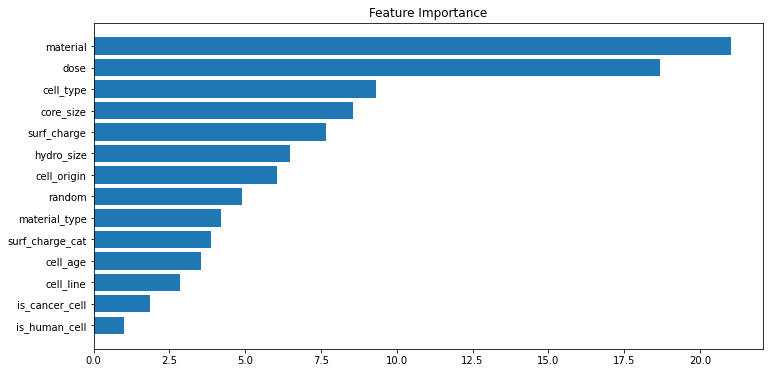

In [ ]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance');


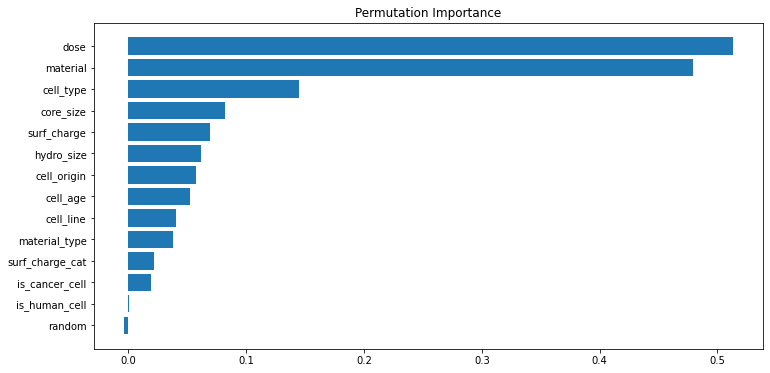

In [ ]:
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Permutation Importance');


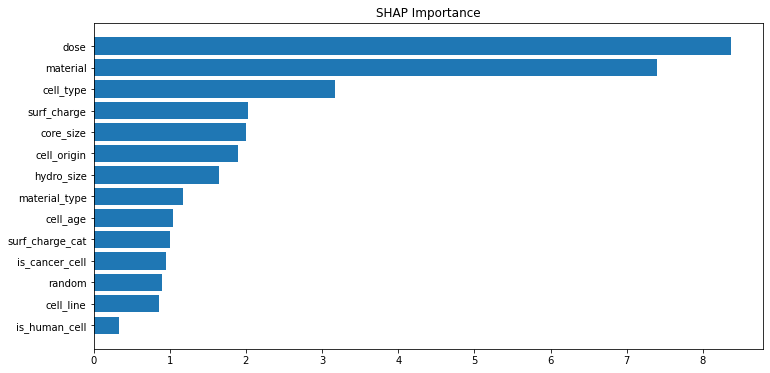

In [ ]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)
shap_importance = shap_values.abs.mean(0).values
sorted_idx = shap_importance.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), shap_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('SHAP Importance');


In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])


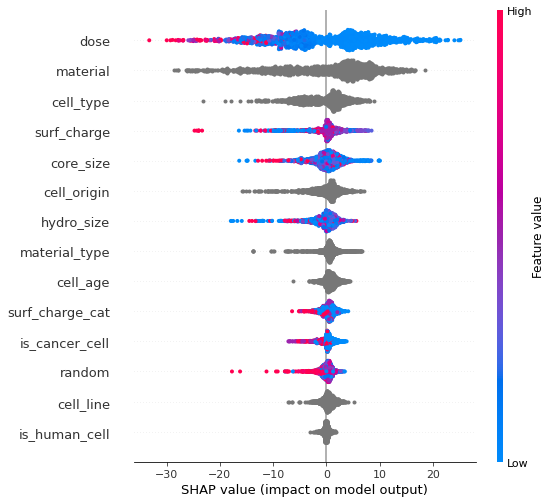

In [ ]:
shap.summary_plot(shap_values, X_test)

5000.0

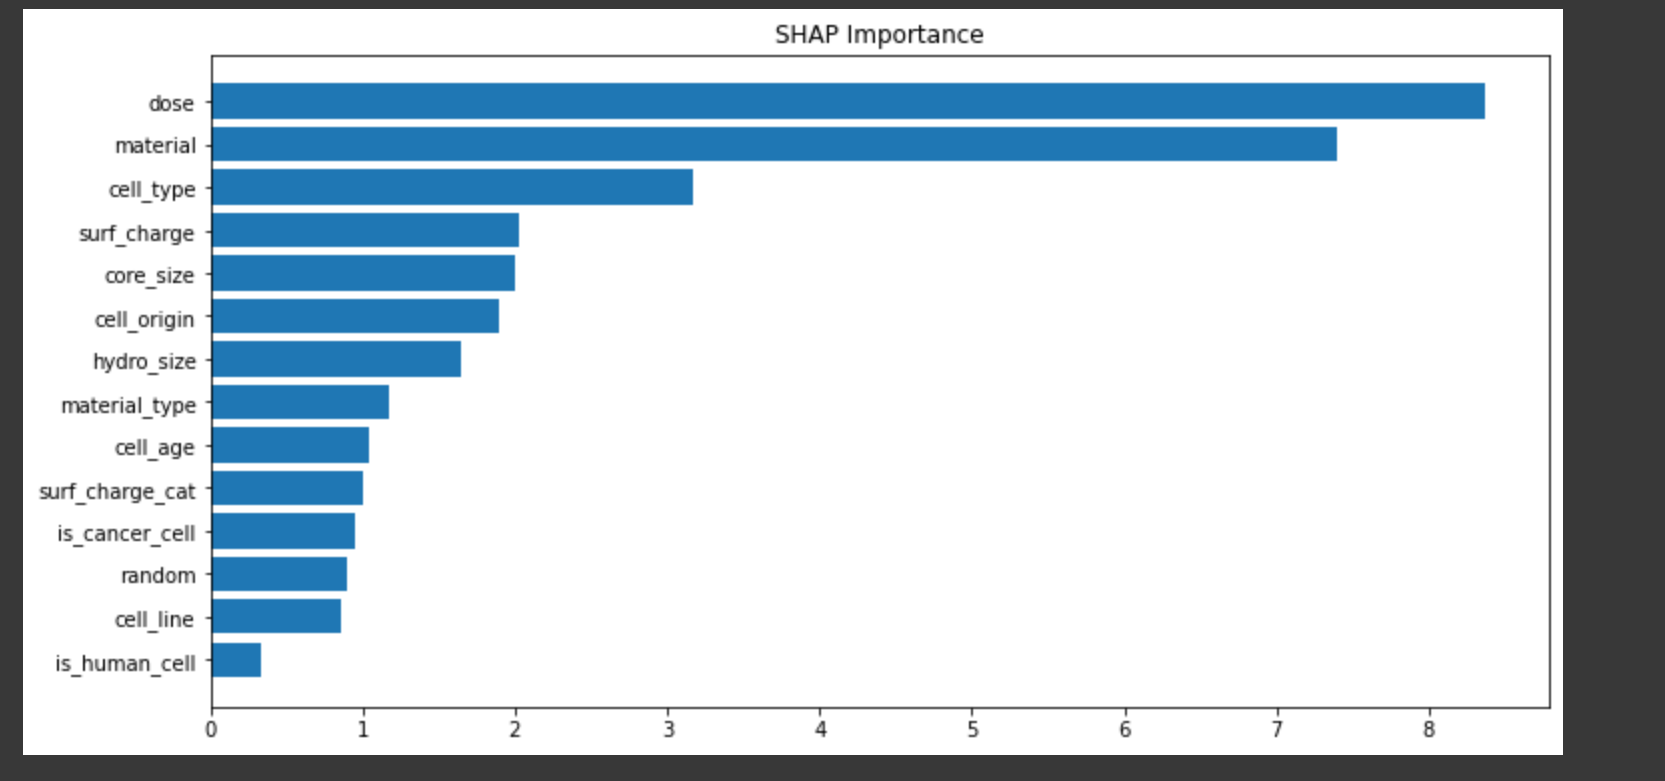

In [ ]:
db.columns

Index(['material', 'core_size', 'hydro_size', 'surf_charge', 'is_cancer_cell',
       'dose', 'viability', 'material_type', 'is_human_cell',
       'surf_charge_cat', 'cell_age', 'cell_origin', 'cell_type', 'cell_line',
       'surf_area', 'time', 'toxicity', 'random'],
      dtype='object')

In [ ]:
dvis = db[db.dose < 200 ]
dvis = dvis[dvis.surf_charge < -40]
dvis = dvis[dvis.surf_charge > -80]
dvis = dvis[dvis.core_size < 40]


In [ ]:
db.shape

In [ ]:
dvis.shape

In [ ]:
dvis = dvis[['dose', 'material', 'cell_type', 'surf_charge', 'core_size', 'hydro_size', 'viability']]
sns.pairplot(dvis)

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f22ee627680> (for post_execute):


KeyboardInterrupt: ignored